In [2]:
"""Example: Forecasting Employee Outflow."""

'Example: Forecasting Employee Outflow.'

# Employee Churn Prediction

In [ ]:
import io
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

# import plotly.express as px
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import f_oneway

# LDA model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# selector object that will use the random forest classifier
# to identify feature importance > 0.10
from sklearn.feature_selection import SelectFromModel

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# performance measurement
# performance measurement
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# feature scaling
# transforming 'salary' catogories into 'int'
# trying Yeo-Johnson transformation
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler

# fmt: off
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Introduction

### Project outline

The purpose of this project is to create a model that will predict whether an employee is likely to stay with the company or leave it based on some of his or her characteristics. The features are given in the Codebook.

As the response variable is a dichotomous categorical variable, three models will be used to predict the outcome: Linear Discriminant Analysis (LDA), Logistic Regression and Random Forest Classifier and then the performance of these models will be compared.

### Codebook

```markdown
Feature                 | Description
------------------------|------------------
`satisfaction_level`    | Employee satisfaction level
`Last_evaluation`       | Last evaluation score
`number_projects`       | Number of projects assigned to
`average_monthly_hours` | Average monthly hours worked
`time_spend_company`    | Time spent at the company
`work_accident`         | Whether they have had a work accident
`left`                  | Whether or not employee left company
`promotion_last_5years` | Whether they have had a promotion in the last 5 years
`department`            | Department name
`salary`                | Salary category
```

## EDA and preprocessing

### Loading and inspecting the data

In [ ]:
load_dotenv()

hr_csv_url = os.environ.get("HR_CSV_URL", "")
response = requests.get(hr_csv_url)
df = pd.read_csv(io.BytesIO(response.content))
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [14]:
# missing values per feature
np.round(df.isna().sum() / len(df), 2)

satisfaction_level       0.0
last_evaluation          0.0
number_project           0.0
average_montly_hours     0.0
time_spend_company       0.0
Work_accident            0.0
left                     0.0
promotion_last_5years    0.0
department               0.0
salary                   0.0
dtype: float64

**Conclusion**. This dataset contains eight explanatory variables and one response variable with information on 14,999 employees. There are no missing values in this dataset.

### Categorical features

#### Work accident

In [15]:
# Work_accident vs. left in percentages
outcome_work_accident = pd.crosstab(
    index=df["left"], columns=df["Work_accident"], normalize="index"
)  # percentages based on index

outcome_work_accident.index = pd.Index(["Did not leave", "Left"])
outcome_work_accident

Work_accident,0,1
Did not leave,0.824991,0.175009
Left,0.952674,0.047326


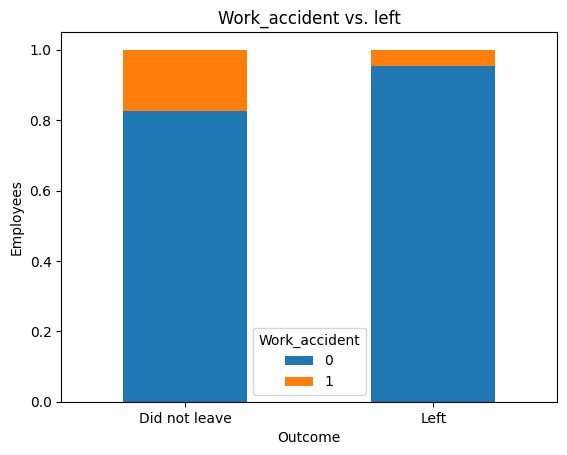

In [16]:
outcome_work_accident.plot(kind="bar", stacked=True)

plt.title("Work_accident vs. left")
plt.xlabel("Outcome")
plt.ylabel("Employees")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

Fewer accidents among those who left

#### Promotion in the last 5 years

In [ ]:
# promotion_last_5years vs. left in percentages
outcome_promotion_last_5years = pd.crosstab(
    index=df["left"], columns=df["promotion_last_5years"], normalize="index"
)

outcome_promotion_last_5years.index = pd.Index(["Did not leave", "Left"])
outcome_promotion_last_5years

promotion_last_5years,0,1
Did not leave,0.973749,0.026251
Left,0.994679,0.005321


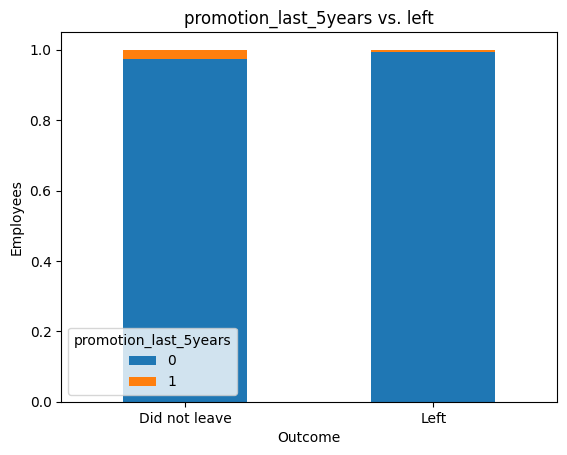

In [18]:
outcome_promotion_last_5years.plot(kind="bar", stacked=True)

plt.title("promotion_last_5years vs. left")
plt.xlabel("Outcome")
plt.ylabel("Employees")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

Almost no promotion among those who left.

#### Department

In [19]:
# department vs. left in percentages
outcome_department = pd.crosstab(
    index=df["left"], columns=df["department"], normalize="index"
)

outcome_department.index = pd.Index(["Did not leave", "Left"])
outcome_department

department,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
Did not leave,0.083479,0.058278,0.049265,0.045852,0.047165,0.057315,0.061603,0.273539,0.146482,0.177021
Left,0.076449,0.033884,0.057127,0.060207,0.025483,0.056847,0.055447,0.283954,0.155419,0.195183


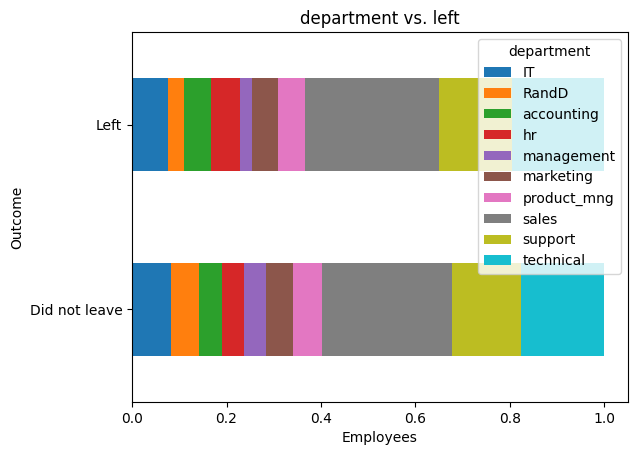

In [20]:
outcome_department.plot.barh(stacked=True)

plt.title("department vs. left")
plt.xlabel("Employees")
plt.ylabel("Outcome")
plt.xticks(rotation=0, horizontalalignment="center")
plt.show()

In [21]:
# number of employees by department
df["department"].value_counts()

department
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

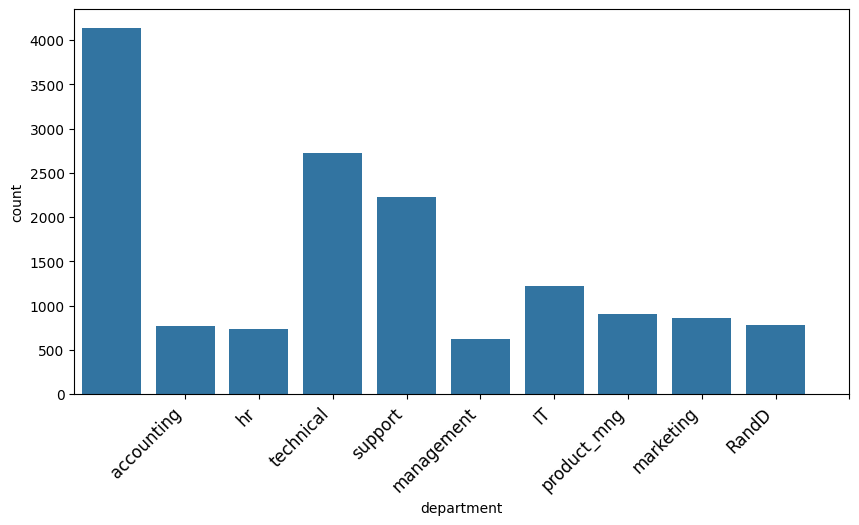

In [22]:
plt.figure(figsize=(10, 5))

chart = sns.countplot(data=df, x="department")

chart.set_xticks(list(range(1, len(df["department"].value_counts()) + 1)))
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
    fontweight="light",
    fontsize="large",
)

plt.show()

Most people work for sales, technical and support departments. Broken down by department, fairly similar distribution among those who left and those who did not leave.

#### Salary

In [23]:
# salary counts
df["salary"].value_counts()

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

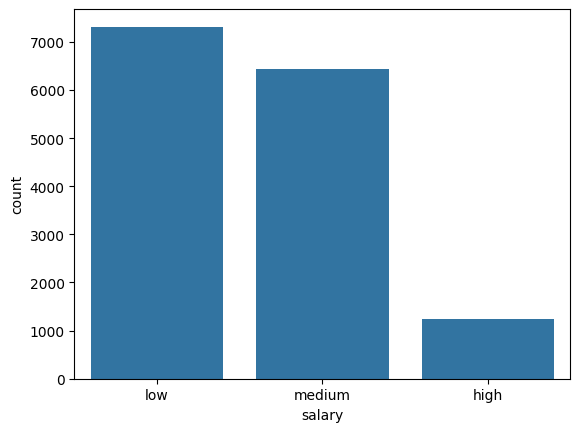

In [24]:
sns.countplot(x="salary", data=df)
plt.show()

In [25]:
# salary vs. department in percentages
salary_dept = pd.crosstab(
    index=df["department"], columns=df["salary"], normalize="index"
)

salary_dept

salary,high,low,medium
department,,,
IT,0.067645,0.496333,0.436023
RandD,0.064803,0.462516,0.472681
accounting,0.096480,0.466754,0.436767
hr,0.060893,0.453315,0.485792
management,0.357143,0.285714,0.357143
marketing,0.093240,0.468531,0.438228
product_mng,0.075388,0.500000,0.424612
sales,0.064976,0.507005,0.428019
support,0.063257,0.514132,0.422611


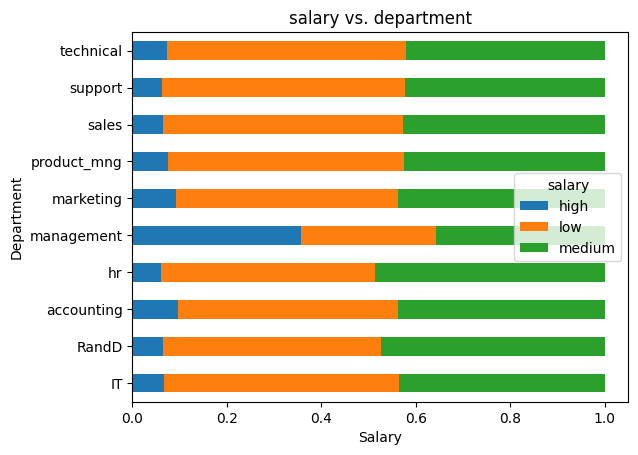

In [26]:
salary_dept.plot.barh(stacked=True)

plt.title("salary vs. department")
plt.xlabel("Salary")
plt.ylabel("Department")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

In [27]:
# salary vs. left in percentages
outcome_salary = pd.crosstab(index=df["left"], columns=df["salary"], normalize="index")

outcome_salary.index = pd.Index(["Did not leave", "Left"])
outcome_salary

salary,high,low,medium
Did not leave,0.101068,0.450123,0.448810
Left,0.022963,0.608233,0.368804


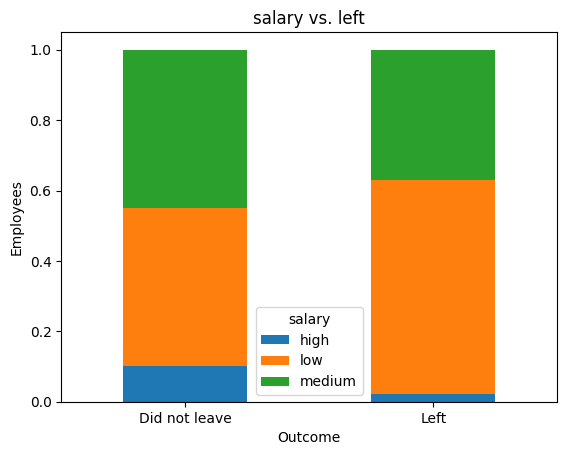

In [28]:
outcome_salary.plot(kind="bar", stacked=True)

plt.title("salary vs. left")
plt.xlabel("Outcome")
plt.ylabel("Employees")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

Low and medium level salary employees significantly outnumber high salary employees. More or less equal distribution of salaries across departments except for managers who have a larger proportion of high salaries. Fewer people with high and medium salary leave.

#### Time spent in the company

In [29]:
# time_spend_company vs. left in percentages
outcome_time_spend_company = pd.crosstab(
    index=df["left"], columns=df["time_spend_company"], normalize="index"
)

outcome_time_spend_company.index = pd.Index(["Did not leave", "Left"])
outcome_time_spend_company

time_spend_company,2,3,4,5,6,7,8,10
Did not leave,0.279226,0.425009,0.14587,0.056003,0.044540,0.016451,0.014176,0.018726
Left,0.014842,0.444133,0.24923,0.233268,0.058527,0.000000,0.000000,0.000000


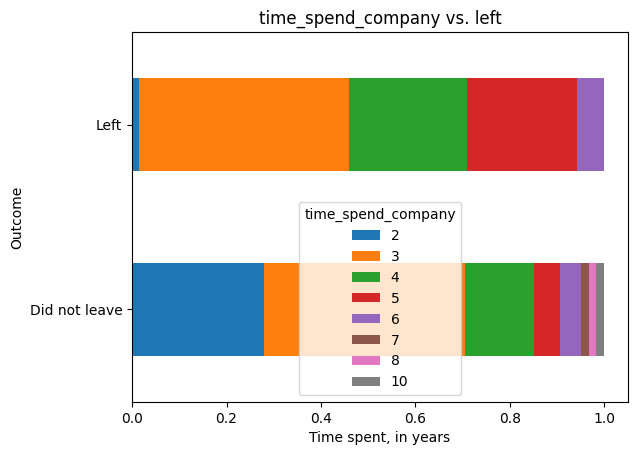

In [30]:
outcome_time_spend_company.plot.barh(stacked=True)

plt.title("time_spend_company vs. left")
plt.xlabel("Time spent, in years")
plt.ylabel("Outcome")

plt.show()

Those who work for 2, 7, 8 and 9 years almost always stay.

#### Number of projects

In [31]:
# mean number_project vs. left
proj_left = df.groupby("left").number_project.mean()
proj_left

left
0    3.786664
1    3.855503
Name: number_project, dtype: float64

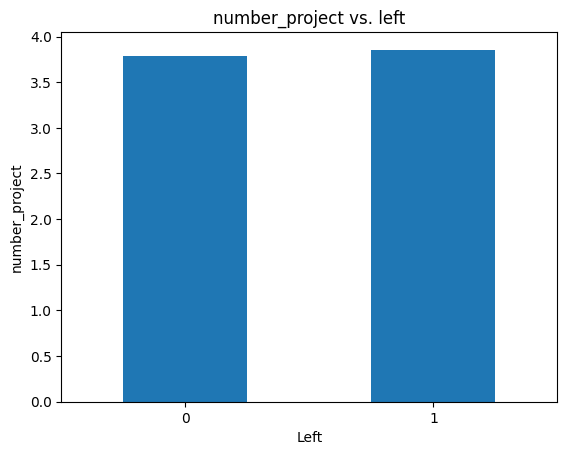

In [32]:
proj_left.plot(kind="bar", stacked=True)

plt.title("number_project vs. left")
plt.xlabel("Left")
plt.ylabel("number_project")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

Mean number of projects' bar plot not very informative.

In [33]:
# number_project vs. left in percentages
outcome_number_project = pd.crosstab(
    index=df["left"], columns=df["number_project"], normalize="index"
)

outcome_number_project.index = pd.Index(["Did not leave", "Left"])
outcome_number_project

number_project,2,3,4,5,6,7
Did not leave,0.071841,0.348530,0.346167,0.188047,0.045415,0.000000
Left,0.438813,0.020162,0.114534,0.171381,0.183422,0.071689


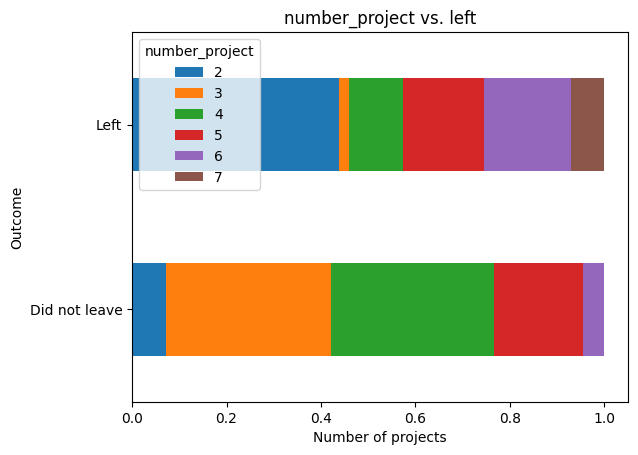

In [34]:
outcome_number_project.plot.barh(stacked=True)

plt.title("number_project vs. left")
plt.xlabel("Number of projects")
plt.ylabel("Outcome")

plt.show()

**Conclusion for categorical variables:** among categorical variables `promotion_last_5years`, `salary`, `time_spend_company`, `number_project` may become good predictors for the model. It is interesting to note that people who had more work related accidents tend to stay more often.

### Numerical features

#### Summary statistics

In [35]:
df[["satisfaction_level", "last_evaluation", "average_montly_hours"]].describe()

,satisfaction_level,last_evaluation,average_montly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,201.050337
std,0.248631,0.171169,49.943099
min,0.090000,0.360000,96.000000
25%,0.440000,0.560000,156.000000
50%,0.640000,0.720000,200.000000
75%,0.820000,0.870000,245.000000
max,1.000000,1.000000,310.000000


Mean and median are quite close. It appears there is no significant skew or ouliers in the distributions.

#### Satisfaction level

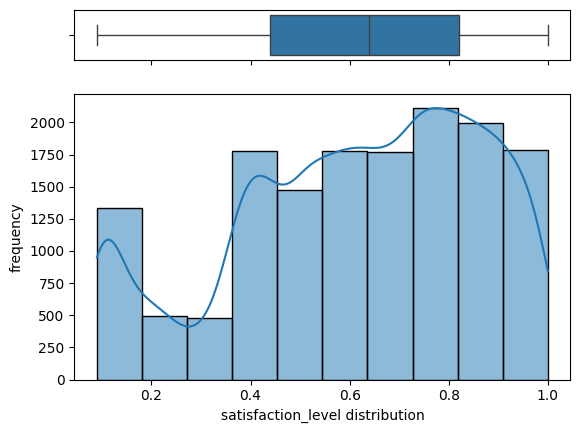

In [36]:
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["satisfaction_level"], ax=ax_box)
sns.histplot(x=df["satisfaction_level"], ax=ax_hist, bins=10, kde=True)

ax_box.set(xlabel="")
ax_hist.set(xlabel="satisfaction_level distribution")
ax_hist.set(ylabel="frequency")

plt.show()

Quite a lot of unsatisfied employees.

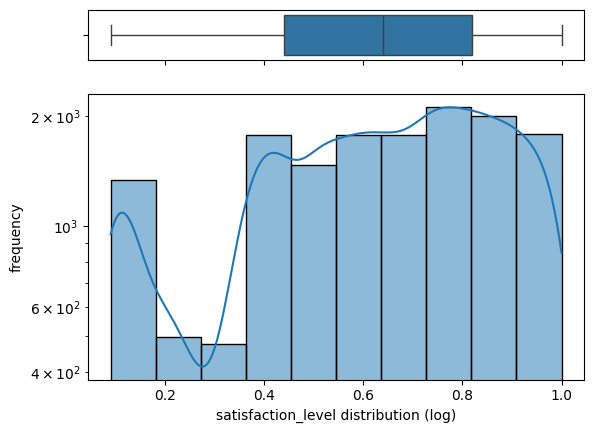

In [37]:
# trying log transformation
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["satisfaction_level"], ax=ax_box)
sns.histplot(x=df["satisfaction_level"], ax=ax_hist, bins=10, kde=True).set_yscale(
    "log"
)

ax_box.set(xlabel="")
ax_hist.set(xlabel="satisfaction_level distribution (log)")
ax_hist.set(ylabel="frequency")

plt.show()

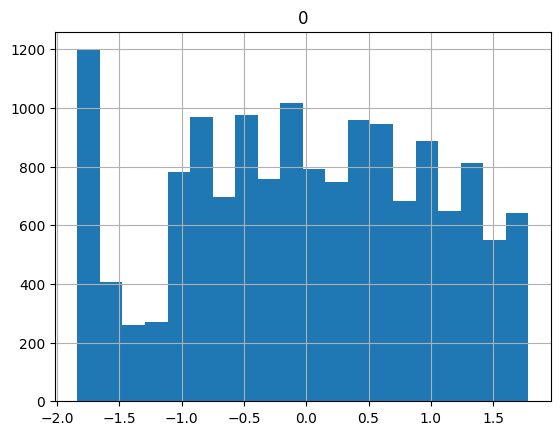

In [38]:
power = PowerTransformer(method="yeo-johnson", standardize=True)
sat_trans = power.fit_transform(df[["satisfaction_level"]])
sat_trans = pd.DataFrame(sat_trans)
sat_trans.hist(bins=20)

plt.show()

In [39]:
# satisfaction level vs. left
sat_left = df.groupby("left").satisfaction_level.mean()
sat_left

left
0    0.666810
1    0.440098
Name: satisfaction_level, dtype: float64

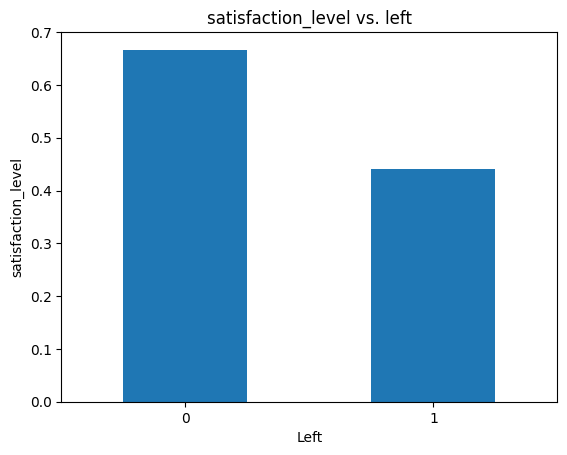

In [40]:
sat_left.plot(kind="bar", stacked=True)

plt.title("satisfaction_level vs. left")
plt.xlabel("Left")
plt.ylabel("satisfaction_level")
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

Those who left are significantly less satisfied.

In [41]:
# satisfaction level by department
sat_dept = df.groupby("department").satisfaction_level.mean().sort_values()
sat_dept

department
accounting     0.582151
hr             0.598809
technical      0.607897
sales          0.614447
IT             0.618142
support        0.618300
marketing      0.618601
product_mng    0.619634
RandD          0.619822
management     0.621349
Name: satisfaction_level, dtype: float64

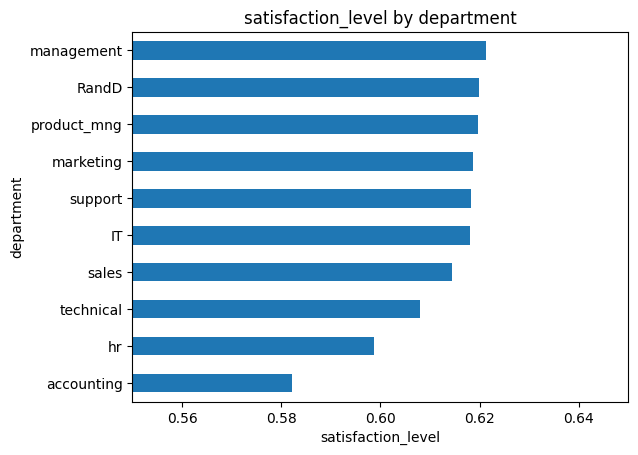

In [42]:
sat_dept.plot.barh(stacked=True)
plt.title("satisfaction_level by department")
plt.xlabel("satisfaction_level")
plt.ylabel("department")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlim(0.55, 0.65)
plt.show()

Accountants, HR and technical people are visibly less satisfied.

#### Last evaluation

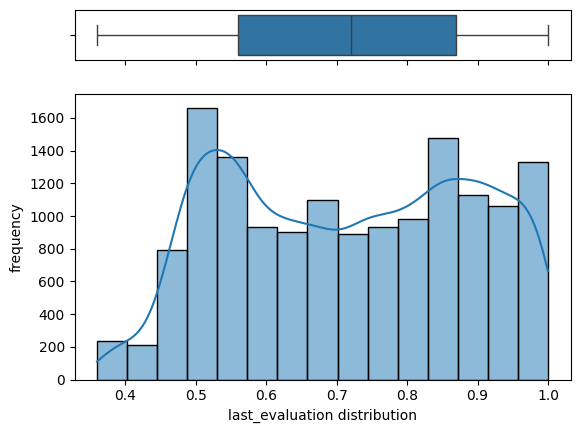

In [43]:
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["last_evaluation"], ax=ax_box)
sns.histplot(x=df["last_evaluation"], ax=ax_hist, bins=15, kde=True)

ax_box.set(xlabel="")
ax_hist.set(xlabel="last_evaluation distribution")
ax_hist.set(ylabel="frequency")

plt.show()

Bimodal distribution.

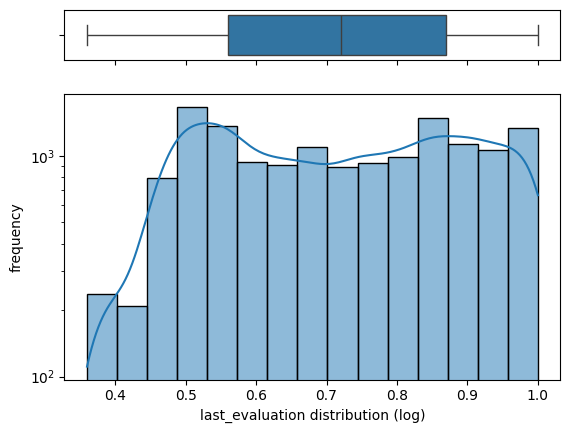

In [44]:
# trying log transformation
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["last_evaluation"], ax=ax_box)
sns.histplot(x=df["last_evaluation"], ax=ax_hist, bins=15, kde=True).set_yscale("log")

ax_box.set(xlabel="")
ax_hist.set(xlabel="last_evaluation distribution (log)")
ax_hist.set(ylabel="frequency")

plt.show()

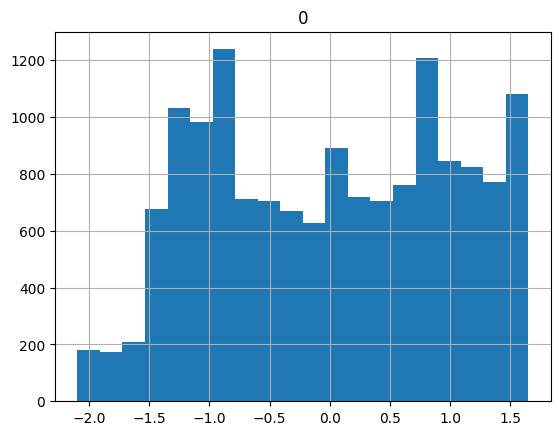

In [45]:
# trying Yeo-Johnson transformation
power = PowerTransformer(method="yeo-johnson", standardize=True)

eval_trans = power.fit_transform(df[["last_evaluation"]])
eval_trans = pd.DataFrame(eval_trans)
eval_trans.hist(bins=20)

plt.show()

In [46]:
# last_evaluation vs. left
eval_left = df.groupby("left").last_evaluation.mean()
eval_left

left
0    0.715473
1    0.718113
Name: last_evaluation, dtype: float64

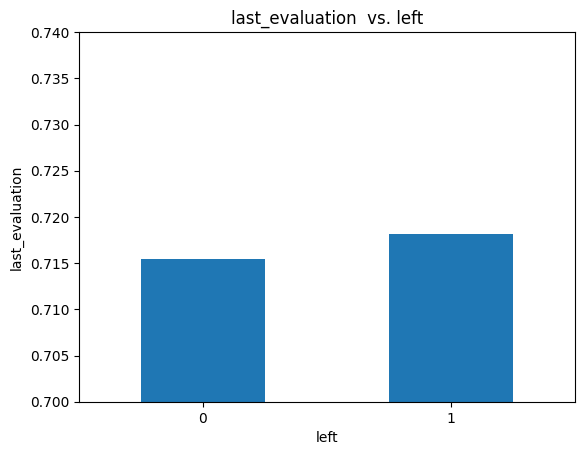

In [47]:
eval_left.plot(kind="bar", stacked=True)

plt.title("last_evaluation  vs. left")
plt.xlabel("left")
plt.ylabel("last_evaluation")
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylim(0.7, 0.74)

plt.show()

The difference is extremely small.

#### Average monthly hours

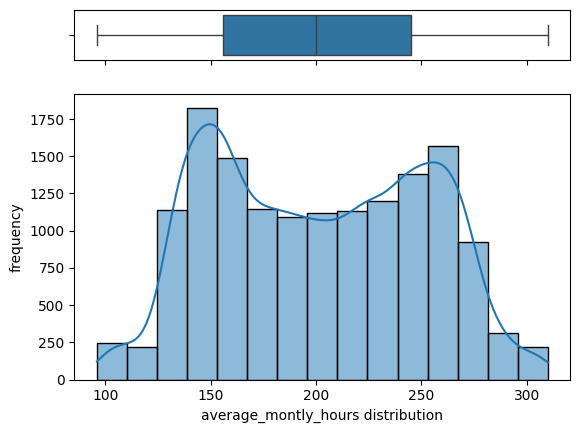

In [48]:
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["average_montly_hours"], ax=ax_box)
sns.histplot(x=df["average_montly_hours"], ax=ax_hist, bins=15, kde=True)

ax_box.set(xlabel="")
ax_hist.set(xlabel="average_montly_hours distribution")
ax_hist.set(ylabel="frequency")

plt.show()

Bimodal distribution.

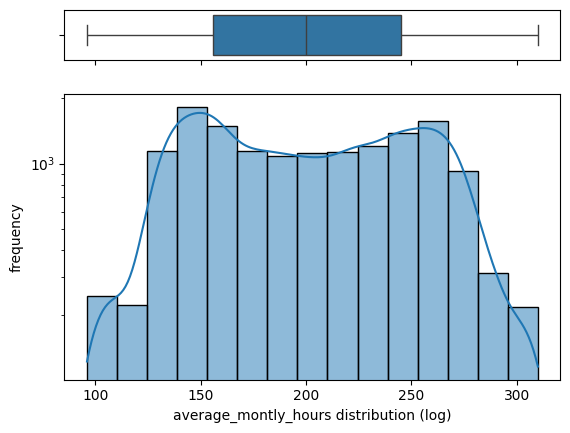

In [49]:
# trying log transformation
a_var, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
)

sns.boxplot(x=df["average_montly_hours"], ax=ax_box)
sns.histplot(x=df["average_montly_hours"], ax=ax_hist, bins=15, kde=True).set_yscale(
    "log"
)

ax_box.set(xlabel="")
ax_hist.set(xlabel="average_montly_hours distribution (log)")
ax_hist.set(ylabel="frequency")

plt.show()

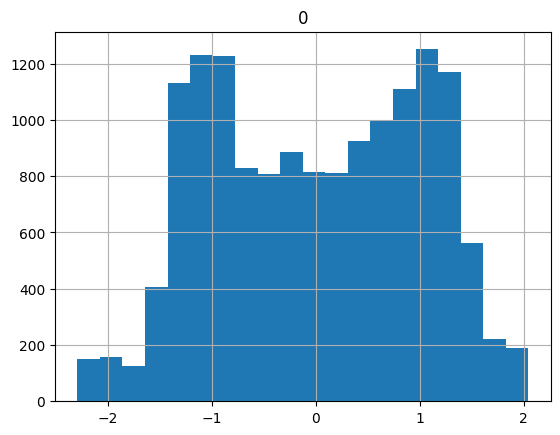

In [50]:
# trying Yeo-Johnson transformation
power = PowerTransformer(method="yeo-johnson", standardize=True)

hours_trans = power.fit_transform(df[["average_montly_hours"]])
hours_trans = pd.DataFrame(hours_trans)
hours_trans.hist(bins=20)

plt.show()

In [51]:
# average_montly_hours vs. left
hours_left = df.groupby("left").average_montly_hours.mean()
hours_left

left
0    199.060203
1    207.419210
Name: average_montly_hours, dtype: float64

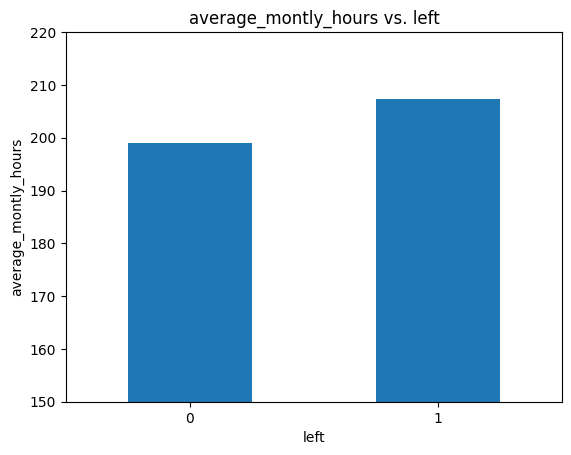

In [52]:
hours_left.plot(kind="bar", stacked=True)

plt.title("average_montly_hours vs. left")
plt.xlabel("left")
plt.ylabel("average_montly_hours")
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylim(150, 220)

plt.show()

**Conclusion for numerical variables:**. Numerical variables require log transformation for better prediction. Yeo-Johnson transformation did not show good results. `satisfaction_level` and `average_montly_hours` may propably be used in the model.

#### Outliers

In [53]:
# satisfaction_level outliers
q1 = df.satisfaction_level.quantile(0.25)
q3 = df.satisfaction_level.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print(lower_bound, upper_bound)

outliers_sat = df[
    (df.satisfaction_level < lower_bound) | (df.satisfaction_level > upper_bound)
]
outliers_sat.head()

-0.12999999999999995 1.39


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary


There are no outliers as boundaries exceed min and max values.

In [54]:
# last_evaluation outliers
q1 = df.last_evaluation.quantile(0.25)
q3 = df.last_evaluation.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print(lower_bound, upper_bound)

eval_outliers = df[
    (df.last_evaluation < lower_bound) | (df.last_evaluation > upper_bound)
]
eval_outliers.head()

0.09500000000000014 1.335


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary


There are no outliers as boundaries exceed min and max values.

In [55]:
# average_montly_hours outliers
q1 = df.average_montly_hours.quantile(0.25)
q3 = df.average_montly_hours.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print(lower_bound, upper_bound)

hours = df[
    (df.average_montly_hours < lower_bound) | (df.average_montly_hours > upper_bound)
]
hours.head()

22.5 378.5


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary


There are no outliers as boundaries exceed min and max values.

### Data investigation

#### Hypothesis 1

We will test the hypothesis that people with high `salary` have higher `average_montly_hours`.

In [56]:
# looking at the means
sal_hours = df.groupby("salary").average_montly_hours.mean().sort_values()
sal_hours

salary
high      199.867421
low       200.996583
medium    201.338349
Name: average_montly_hours, dtype: float64

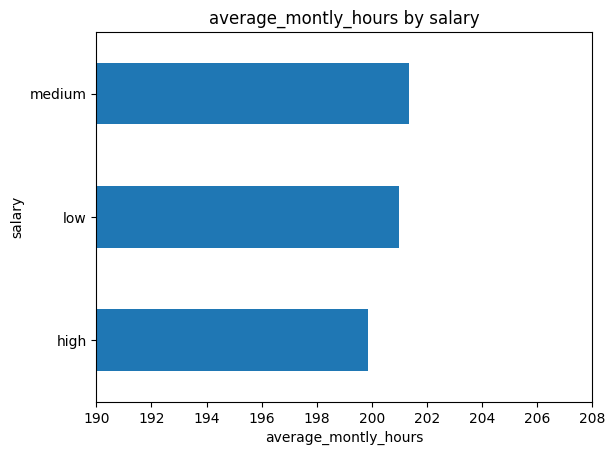

In [57]:
sal_hours.plot.barh(stacked=True)

plt.title("average_montly_hours by salary")
plt.xlabel("average_montly_hours")
plt.ylabel("salary")
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlim(190, 208)

plt.show()

Actually, those who have a medium salary appear to work slightly longer hours being the difference though quite small. We can test whether there is a statistically significant difference with ANOVA.

In [58]:
# splitting data into three samples
low = df[df["salary"] == "low"]
low = low[["average_montly_hours"]]

medium = df[df["salary"] == "medium"]
medium = medium[["average_montly_hours"]]

high = df[df["salary"] == "high"]
high = high[["average_montly_hours"]]

In [59]:
# size of each sample
print(len(low), len(medium), len(high))

7316 6446 1237


In [60]:
f_oneway(low, medium, high)

F_onewayResult(statistic=array([0.45836244]), pvalue=array([0.63232712]))

The size of the samples is quite significant so we would expect the test to detect even small differences. Nevertheless, p-value is still greater than 0.05 and thus ANOVA shows that there is no significant difference between `average_montly_hours` in terms of salary.

### Data Transformation

In [ ]:
# basic assumption for LDA is that numeric variables have to be normal
# log transformation of numerical variables
df["sat_level_log"] = np.log(df["satisfaction_level"])
df["last_eval_log"] = np.log(df["last_evaluation"])
df["av_hours_log"] = np.log(df["average_montly_hours"])

# changing column order
columns_titles = [
    "satisfaction_level",
    "sat_level_log",
    "last_evaluation",
    "last_eval_log",
    "number_project",
    "average_montly_hours",
    "av_hours_log",
    "time_spend_company",
    "Work_accident",
    "promotion_last_5years",
    "department",
    "salary",
    "left",
]
df = df.reindex(columns=columns_titles)

In [62]:
labelencoder = LabelEncoder()
df["salary"] = labelencoder.fit_transform(df["salary"])

In [63]:
# transforming 'deparment' catogories into 'int'
labelencoder = LabelEncoder()
df["department"] = labelencoder.fit_transform(df["department"])

In [64]:
df.head()

,satisfaction_level,sat_level_log,last_evaluation,last_eval_log,number_project,average_montly_hours,av_hours_log,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,-0.967584,0.53,-0.634878,2,157,5.056246,3,0,0,7,1,1
1,0.80,-0.223144,0.86,-0.150823,5,262,5.568345,6,0,0,7,2,1
2,0.11,-2.207275,0.88,-0.127833,7,272,5.605802,4,0,0,7,2,1
3,0.72,-0.328504,0.87,-0.139262,5,223,5.407172,5,0,0,7,1,1
4,0.37,-0.994252,0.52,-0.653926,2,159,5.068904,3,0,0,7,1,1


### Correlation Analysis

Kendall correlation method will be used for the correlation analysis.

In [65]:
df_c = df[
    [
        "satisfaction_level",
        "sat_level_log",
        "last_evaluation",
        "last_eval_log",
        "number_project",
        "average_montly_hours",
        "av_hours_log",
        "time_spend_company",
        "Work_accident",
        "promotion_last_5years",
        "salary",
    ]
]

# df_c.corr()

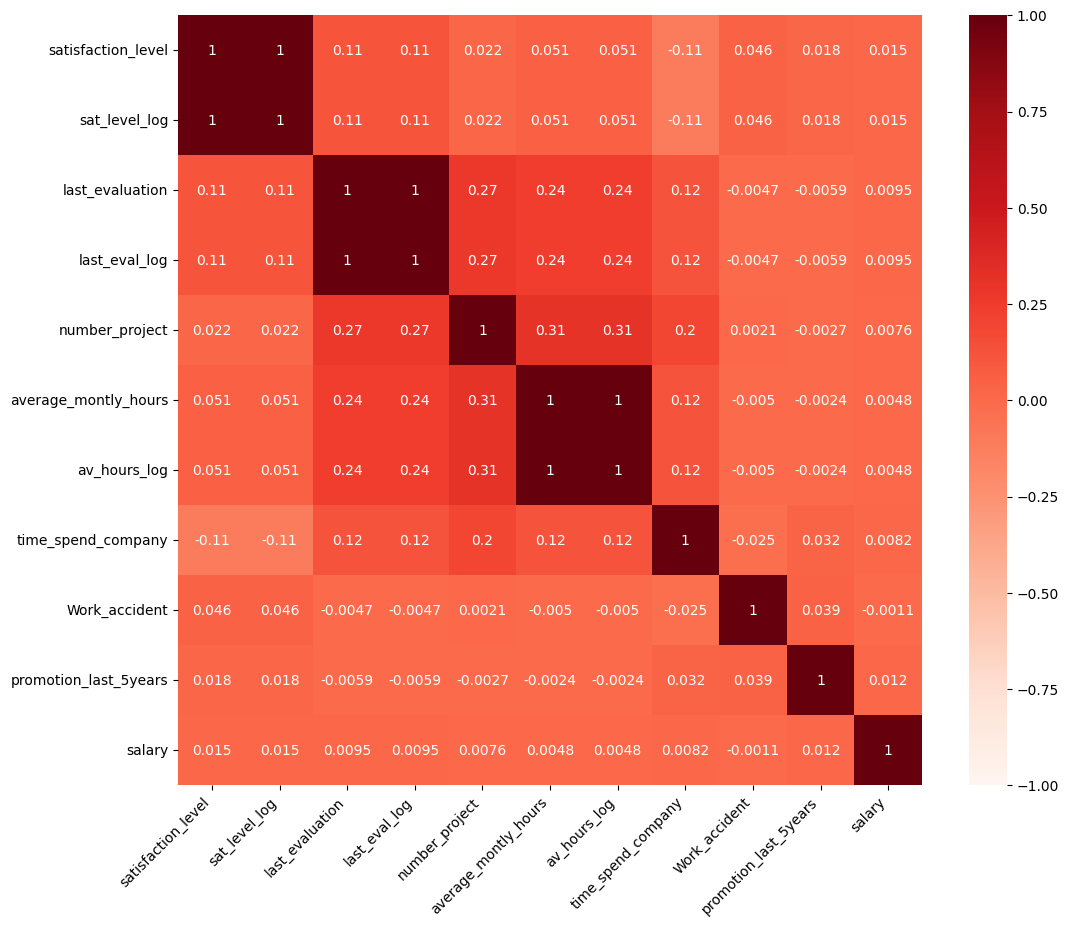

In [66]:
# Kendall Correlation matrix
plt.figure(figsize=(12, 10))

cor = df_c.corr(method="kendall")

ax = sns.heatmap(
    cor, annot=True, vmin=-1, vmax=1, center=0, cmap=plt.cm.Reds
)  # cmap = sns.diverging_palette(20, 220, n = 200)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.show()

In [67]:
# largest and smallest correlation
c_var = df_c.corr(method="kendall").abs()
d_var = c_var.unstack()
so = d_var.sort_values(kind="quicksort")  # type: ignore[call-overload]

In [68]:
print(so[-22:-17])

number_project        last_eval_log           0.266267
                      av_hours_log            0.306987
average_montly_hours  number_project          0.306987
av_hours_log          number_project          0.306987
number_project        average_montly_hours    0.306987
dtype: float64


In [69]:
print(so[:4])

Work_accident   salary            0.001077
salary          Work_accident     0.001077
number_project  Work_accident     0.002096
Work_accident   number_project    0.002096
dtype: float64


The two lowest correlations include `salary` and `Work_accident`, and `number_project` and `Work_accident`.

### Multicollinearity analysis

In [70]:
warnings.filterwarnings("ignore")

# Getting variables for which to compute VIF and adding intercept term
e_var = df[
    [
        "satisfaction_level",
        "last_eval_log",
        "number_project",
        "average_montly_hours",
        "time_spend_company",
        "Work_accident",
        "promotion_last_5years",
    ]
]

e_var["Intercept"] = 1

In [71]:
# X.head()

In [72]:
# Compute and view VIF
vif = pd.DataFrame()
vif['variables'] = e_var.columns
vif["VIF"] = [
    variance_inflation_factor(e_var.values, i)
    for i in range(e_var.shape[1])
]

# View results using print
print(vif)
# fmt: on

               variables        VIF
0     satisfaction_level   1.067160
1          last_eval_log   1.246795
2         number_project   1.355188
3   average_montly_hours   1.281311
4     time_spend_company   1.058839
5          Work_accident   1.005208
6  promotion_last_5years   1.007573
7              Intercept  48.504410


As VIF is closer to 1, we can say that there is moderate correlation between explanatory variables.

## Modelling

### Linear Discriminant Analysis

In [73]:
# trying different features
df_model = df[
    [
        "satisfaction_level",
        "last_eval_log",
        "number_project",
        "average_montly_hours",
        "time_spend_company",
        "Work_accident",
        "promotion_last_5years",
    ]
]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model, df["left"], test_size=0.30, random_state=42
)

In [75]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [76]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [77]:
# making prediction
lda.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(4500,))

In [78]:
accuracy_score(y_test, lda.predict(X_test))

0.7557777777777778

### Logistic Regression

In [79]:
# trying different features
df_model_2 = df[
    [
        "satisfaction_level",
        "last_eval_log",
        "number_project",
        "average_montly_hours",
        "time_spend_company",
        "Work_accident",
        "promotion_last_5years",
    ]
]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model_2, df["left"], test_size=0.30, random_state=42
)

In [81]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [82]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [83]:
print(confusion_matrix(y_test, lr.predict(X_test)))
print(accuracy_score(y_test, lr.predict(X_test)))

[[3160  268]
 [ 816  256]]
0.7591111111111111


### Random Forest Classifier

In [84]:
# trying different features
df_model_3 = df[
    [
        "satisfaction_level",
        "last_eval_log",
        "number_project",
        "average_montly_hours",
        "time_spend_company",
        "Work_accident",
        "promotion_last_5years",
        "department",
        "salary",
    ]
]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model_3, df["left"], test_size=0.30, random_state=42
)

In [86]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [87]:
classifier = RandomForestClassifier(
    criterion="gini",
    n_estimators=100,
    max_depth=9,
    random_state=42,
    n_jobs=-1,
)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
# test performance measurement
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3418   10]
 [  95  977]]
0.9766666666666667


Trying **feature selection** to reduce the variance of the model, and therefore overfitting.

In [89]:
feat_labels = [
    "satisfaction_level",
    "last_eval_log",
    "number_project",
    "average_montly_hours",
    "time_spend_company",
    "Work_accident",
    "promotion_last_5years",
    "department",
    "salary",
]

In [90]:
# name and gini importance of each feature
for feature in zip(feat_labels, classifier.feature_importances_):
    print(feature)

('satisfaction_level', np.float64(0.33518238819427854))
('last_eval_log', np.float64(0.11467868669774808))
('number_project', np.float64(0.19991554815436824))
('average_montly_hours', np.float64(0.15054996293765044))
('time_spend_company', np.float64(0.1849053997672037))
('Work_accident', np.float64(0.0043681189902708825))
('promotion_last_5years', np.float64(0.0007858384076546757))
('department', np.float64(0.004841179779207061))
('salary', np.float64(0.004772877071618341))


In [91]:
sfm = SelectFromModel(classifier, threshold=0.10)

# training the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=9, n_jobs=-1,
                                                 random_state=42),
                threshold=0.1)

In [92]:
# names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

satisfaction_level
last_eval_log
number_project
average_montly_hours
time_spend_company


In [93]:
# transforming the data to create a new dataset containing only
# the most important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [94]:
# new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [95]:
# applying the full featured classifier to the test data
y_important_pred = clf_important.predict(X_important_test)

# view the accuracy of limited feature model
accuracy_score(y_test, y_important_pred)

0.9886666666666667

## Conclusion

In this research we decided to compare LDA, Logistic Regression and Random Forest Classifier models. As the data are highly skewed, sometimes bimodal and include categorical variables, the Random Forest Classifier model performed the best with an accuracy of 97.7%. Feature importance selection allowed to improve the accuracy up to 98.9% and at the same time reduced the complexity of the model.